# Data description & Problem statement: 
   The dataset is related with a mortgage loan and challenge is to predict approval status of loan (Approved/Reject). Needless to mention that, among all industries, the insurance domain has one of the largest uses of analytics & data science methods. 
* Dataset is imbalanced. The data has 615 rows and 13 columns.
* This is a classification problem. I will predict if a loan will get approved or not.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training and test part for the final evaluation of model)
   #  Model Training:
- Train an ensemble of Deep Neural Network models by Keras/Tensorflow, and finally aggregate the results (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the Neural Network model on Test Dataset, by calculating:
     - AUC score:  0.81
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision:  0.81

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Loan prediction/train_loanPrediction.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.drop('Loan_ID', axis=1, inplace=True)

L_c=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status' ]
L_n=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df_selected=df[['Credit_History', 'ApplicantIncome', 'LoanAmount', 'CoapplicantIncome' , 'Property_Area', 'Loan_Status']]

df_selected.dropna( axis=0, inplace=True)
df_selected.shape

(543, 6)

In [5]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


for i in [ 'Property_Area', 'Loan_Status' ]:
    encode_text_index(df_selected, i)
    
df_selected.head(3)

,Credit_History,ApplicantIncome,LoanAmount,CoapplicantIncome,Property_Area,Loan_Status
1,1.0,4583,128.0,1508.0,0,0
2,1.0,3000,66.0,0.0,2,1
3,1.0,2583,120.0,2358.0,2,1


In [6]:
X=df_selected.drop(['Loan_Status'], axis=1)
y=df_selected['Loan_Status']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

remove_outliers(X_train, y_train, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], thresh=6)

number of outliers removed :   7


In [7]:
# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#X_r, y_r = X_train, y_train
X_r, y_r = SMOTE(random_state=42,  kind='svm').fit_sample(X_train, y_train)
#X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)

from keras.utils import to_categorical
y_r=to_categorical(y_r)
y_test=to_categorical(y_test)

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

scalor_X=MinMaxScaler().fit(X)
X_r=scalor_X.transform(X_r)
X_test=scalor_X.transform(X_test)

In [9]:
# KNN with Cross-Validation:
from sklearn.metrics import roc_auc_score
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, average, Input, merge, concatenate
from keras.layers.merge import concatenate
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_sample_weight
from keras.layers.normalization import BatchNormalization

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

# a single input layer
inputs = Input(shape=(X_r.shape[1],))

# model 1
x1 = Dense(600, activation='relu',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(inputs)
x1 = Dropout(0.2)(x1)
x1 = Dense(500, activation='relu',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(200, activation='sigmoid',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(x1)


# model 2 
x2 = Dense(600, activation='relu',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(inputs)
x2 = Dropout(0.2)(x2)
x2 = Dense(500, activation='sigmoid',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(x2)
x2 = Dropout(0.3)(x2)
x2 = Dense(200, activation='relu',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(x2)

# model 3 
x3 = Dense(600, activation='linear',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(inputs)
x3 = Dropout(0.2)(x3)
x3 = Dense(500, activation='relu',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(x3)
x3 = Dropout(0.3)(x3)
x3 = Dense(200, activation='relu',  activity_regularizer=l2(0.0005), kernel_initializer='glorot_uniform')(x3)


# merging models
model_ave = average([x1, x2, x3])

# output layer
outs = Dense(2, activation='softmax', activity_regularizer=l2(0.005))(model_ave)

#generate a model from the layers above
model = Model(inputs=inputs, outputs=outs)
model.compile(optimizer='adam',  loss='categorical_crossentropy')


monitor=EarlyStopping(monitor='loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
history=model.fit(X_r,y_r, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[monitor, checkpointer], verbose=0)
model.load_weights('best_weights.hdf5')

# Measure this fold's accuracy
auc_test=roc_auc_score(y_test, model.predict(X_test))
auc_train=roc_auc_score(y_r, model.predict(X_r))

print('Training auc score: ', auc_train, "\n")
print('Validation auc score: ', auc_test)

Training auc score:  0.9142985525796217 

Validation auc score:  0.8075000000000001


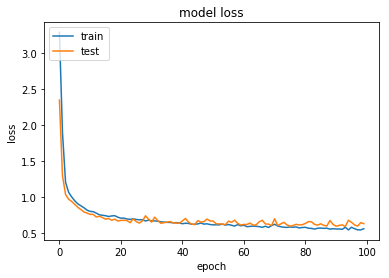

In [10]:
# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[20 16]
 [ 6 94]]
Normalized confusion matrix
[[0.56 0.44]
 [0.06 0.94]]


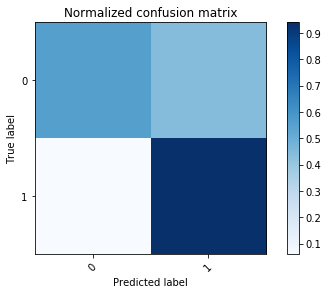

In [11]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [12]:
# Classification report:
report=classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print(report)

             precision    recall  f1-score   support

          0       0.77      0.56      0.65        36
          1       0.85      0.94      0.90       100

avg / total       0.83      0.84      0.83       136



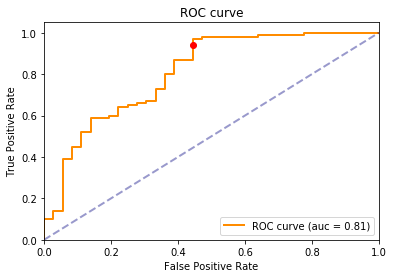

In [13]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test[:, 1]), model.predict(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), model.predict(X_test))

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

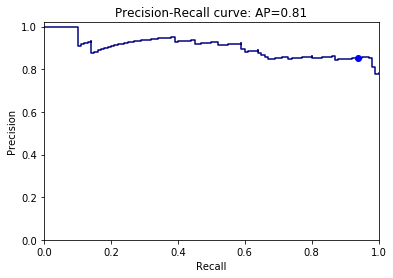

In [14]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test[:, 1], model.predict(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test, model.predict(X_test))

plt.step( recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot( [cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()